# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
from mycode import MNISTprep

MNISTprep.prepData()

Using TensorFlow backend.


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
Generating sequence data complete.
(100000, 1, 64, 64) (100000, 11, 5) (100000, 5)
(30000, 1, 64, 64) (30000, 11, 5) (30000, 5)
[[    0 20164 40130 60143 80099]
 [ 9965  7841  5952  4032  1979]
 [11277  8933  6605  4372  2202]
 [ 9748  8011  5957  4009  1929]
 [10419  8253  6100  3995  2074]
 [ 9738  7766  5938  3873  1968]
 [ 9006  7313  5484  3524  1780]
 [ 9810  8109  5850  3926  1943]
 [10566  8152  6267  4222  2127]
 [ 9694  7706  5760  3933  1947]
 [ 9777  7752  5957  3971  1952]]


[20164 19966 20013 19956 19901]
Compressed pickle size: 2137720461


In [2]:
# This cell is for illustration purposes.
# The actual training was performed on a GPU-enabled server and used nb_epoch=100.

from mycode import MNISTconvnet

MNISTconvnet.trainConvnet(nb_epoch=1)

Training set: (100000, 1, 64, 64) (100000, 11, 5) (100000, 5)
Test set: (30000, 1, 64, 64) (30000, 11, 5) (30000, 5)
Train on 97000 samples, validate on 3000 samples
Epoch 1/1
912s - loss: 7.8944 - activation_10_loss: 0.3050 - activation_11_loss: 1.4210 - activation_12_loss: 1.6012 - activation_13_loss: 1.5045 - activation_14_loss: 1.5002 - activation_15_loss: 1.5626 - activation_10_categorical_accuracy: 0.9899 - activation_11_categorical_accuracy: 0.5667 - activation_12_categorical_accuracy: 0.4599 - activation_13_categorical_accuracy: 0.5452 - activation_14_categorical_accuracy: 0.6450 - activation_15_categorical_accuracy: 0.8010 - val_loss: 5.2822 - val_activation_10_loss: 0.1367 - val_activation_11_loss: 0.5701 - val_activation_12_loss: 1.0751 - val_activation_13_loss: 1.0893 - val_activation_14_loss: 1.2331 - val_activation_15_loss: 1.1779 - val_activation_10_categorical_accuracy: 1.0000 - val_activation_11_categorical_accuracy: 0.8447 - val_activation_12_categorical_accuracy: 0.6

In [1]:
from mycode import MNISTeval

MNISTeval.evaluate()

Using TensorFlow backend.


30000/30000 [==============================] - 72s    

[0.34599059230188528, 2.377030143009809e-05, 0.073934230960781375, 0.080711769734385111, 0.073486211038256685, 0.067933976947857688, 0.049900634064463274, 1.0, 0.9781333333333333, 0.97636666666666672, 0.97926666666666662, 0.98023333333333329, 0.98536666666666661]

Accuracy on test set: 0.9049


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** I first designed a multilayer convolutional network, based on the Keras documentation (https://keras.io/getting-started/sequential-model-guide/#examples), and made certain it performed well on single digits from the Keras MNIST dataset.

Next I modified the data sets to use random combinations of up to five samples from the MNIST data and added parallel softmax outputs in a similar fashion to the Google architecture linked above. This model was almost 80% accurate on 5-digit combinations and >95% accurate on single digits.

Adding in additional convoluational layers to more closely match the Google architecture has increased the accuracy to **90.5%** on 5-digit combinations and ~98% accuracy per digit (above).

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** My final archecture uses eight convoluational layers, one large dense layers, and then a small dense layer for each of the six outputs (length of sequence and five digits). Each convolution layer uses maxpooling and batch normalization. All layers use ReLu activation, except the output, which use Softmax. All layers but the input and output use dropout. A full summary of the model is included below.

In [3]:
from keras.models import Model, load_model

clf = load_model('MNIST-1.h5')
clf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 64, 64)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 1, 64, 48)     76848       input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1, 64, 48)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 1, 64, 48)     0           activation_1[0][0]               
___________________________________________________________________________________________

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:** I trained my model using the adadelta optimizer. Researching similar image classification problems indicated that Adam and Adadelta are common choices for this type of application. I chose to use a batch size of 256, but didn't thoroughly test adjusting this parameter.

I tested generating my synthetic dataset a few different ways, but settled on generating a random sequence length, fetching that number of random samples from the training or test sets, concatenating those images together, then resizing the resulting image back to 64x64. 100,000 new training samples were generated using the original training data and 30,000 new testing samples were generated using the original testing data.

Samples of generated images can be found below.

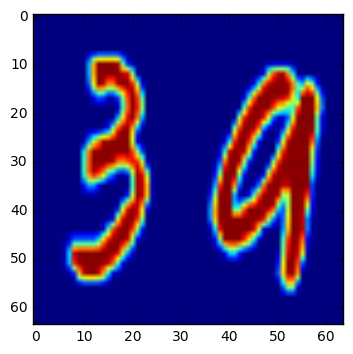

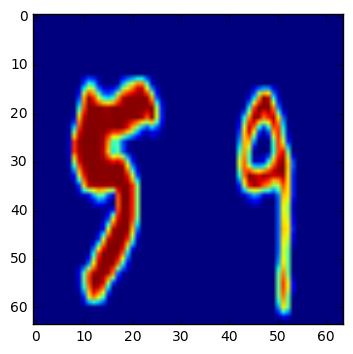

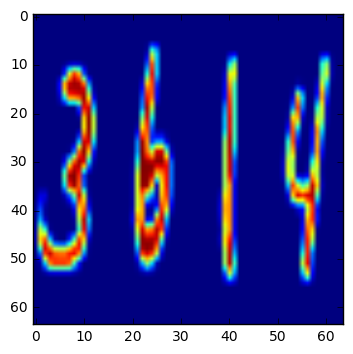

In [7]:
import numpy as np
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

pickle_file = 'MNIST-1.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    train_sequences = save['train_sequences']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    test_sequences = save['test_sequences']
    del save

for foo in range(3):
    image = np.array(train_dataset[np.random.randint(train_dataset.shape[0]), 0, :, :])
    plt.figure()
    plt.imshow(image)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
from mycode import SVHNprep1

SVHNprep1.prepData()

Found and verified train.tar.gz
Found and verified test.tar.gz
train already present - Skipping extraction of train.tar.gz.
train data extraction complete.
test already present - Skipping extraction of test.tar.gz.
test data extraction complete.
Compressed pickle size: 4139486


In [6]:
from mycode import SVHNprep2

SVHNprep2.prepData()

Train dictionary: 33402
Test dictionary: 13068
Skipped zero-size bbox image: 11861.png
Skipped zero-size bbox image: 13145.png
Skipped zero-size bbox image: 15125.png
Skipped zero-size bbox image: 18277.png
Skipped zero-size bbox image: 18393.png
Skipped zero-size bbox image: 19383.png
Skipped zero-size bbox image: 20540.png
Skipped zero-size bbox image: 20901.png
Skipped zero-size bbox image: 20915.png
Skipped zero-size bbox image: 22442.png
Skipped zero-size bbox image: 23905.png
Skipped zero-size bbox image: 252.png
Skipped zero-size bbox image: 26570.png
Skipped zero-size bbox image: 27638.png
Skipped zero-size bbox image: 27809.png
Skipped zero-size bbox image: 28513.png
Skipped zero-size bbox image: 28798.png
Skipped zero-size bbox image: 28818.png
Skipped zero-size bbox image: 28850.png
Skipped zero-size bbox image: 29759.png
Image 29930.png has too many digits!
Skipped zero-size bbox image: 30510.png
Skipped zero-size bbox image: 30953.png
Skipped zero-size bbox image: 3100.png

In [7]:
# This cell is for illustration purposes.
# The actual training was performed on a GPU-enabled server and used nb_epoch=1000.

from mycode import SVHNconvnet

SVHNconvnet.trainConvnet(nb_epoch=1)

Training set (33372, 1, 64, 64) (33372, 11, 5) (33372, 5) (33372, 25)
Test set (13060, 1, 64, 64) (13060, 11, 5) (13060, 5) (13060, 25)
Training sequence distribution: [ 5133 18111  8685  1434     9]
Testing sequence distribution: [2482 8350 2080  146    2]


[[    0  5133 23244 31929 33363]
 [ 9233  3327  1128   156     2]
 [ 6316  3128   983   150     0]
 [ 4342  2966  1057   120     2]
 [ 3509  2807   979   160     0]
 [ 2828  2867  1045   134     1]
 [ 2152  2489   953   130     0]
 [ 1877  2633   960   115     2]
 [ 1582  2378   939   140     0]
 [ 1449  2281   805   121     1]
 [   84  3363  1279   217     1]]


[[    0  2482 10832 12912 13058]
 [ 3693  1144   244    17     0]
 [ 2655  1232   243    16     0]
 [ 1625  1026   217    13     0]
 [ 1235  1080   198     9     0]
 [ 1051  1078   242    12     0]
 [  856   918   182    17     0]
 [  747  1018   239    12     1]
 [  623   835   192     8     0]
 [  556   848   176    15     0]
 [   19  1399   295    29     1]]
Train on 3

In [8]:
from mycode import SVHNeval

SVHNeval.evaluate()

13060/13060 [==============================] - 31s    

[1.5744000890524701, 0.19369711850177579, 0.45661032277349795, 0.57601497988480432, 0.29752699457572318, 0.048145505406504786, 0.0024051673322280291, 0.95773353751914247, 0.88629402756508424, 0.86508422664624807, 0.93032159264931091, 0.98996937212863712, 0.99977029096477799]

Accuracy on test set: 0.759418070444


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:** To prepare the training and testing data, I looped through all of the files in the two directories and pulled each image's sequence information from the digitStruct files. To make the images consistent, I resized them to 64x64 pixels and converted them to greyscale. Later, I also cropped the images to the bounding boxes.

Using the same model that achieved 90.5% accuracy on the previous dataset, the SVHN data was only able to reach an accuracy of 17% on uncropped images and 75.9% on cropped images.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:** I tested many different options for improving performance, but ultimately it came down to improving the dataset. When I first trained this network, it was on the unmodified images and only produced 17% accuracy. After testing many variations on the model structure and number of nodes, I was only able to achieve 27.9% accuracy on the test set. Many alterations did in fact lower the model's performance.

Ultimately, the biggest improvement came from re-generating the test set data to crop to the bounding boxes before resizing to 64x64 pixels. Reducing the large dense layer led to small improvements in test accuracy, but the best model came from setting the dense layer size to 3096 nodes and running it much longer (1000 epochs). This produced an accuracy of 75.9%.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:** Initial result: 17.4% accuracy. Final result: 75.9% accuracy. This model is still not doing a good enough job at classifying numbers to be very useful in a real world application, but is sufficiently good to attempt classifying pictures of numbers that I take myself.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
from mycode import photosEval

photosEval.evaluate(notebook=True)

Images loaded: 8
(8, 1, 64, 64) (8, 11, 5) (8, 5)
131.702
8/8 [==============================] - 0s

[6.2859048843383789, 0.32697659730911255, 2.2814059257507324, 3.0861306190490723, 0.12028408795595169, 0.47104388475418091, 6.3302693888545036e-05, 0.875, 0.625, 0.5, 1.0, 0.875, 1.0]

Accuracy on photos: 0.5


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:** The photos I took include a mix of different font styles, colors, textures, and luminance. There were initially a number of extra distractors in each photo, but I cropped them further in order to try to improve results.

Images loaded: 8


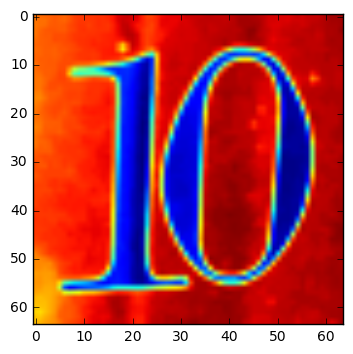

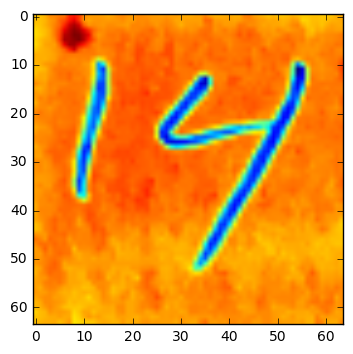

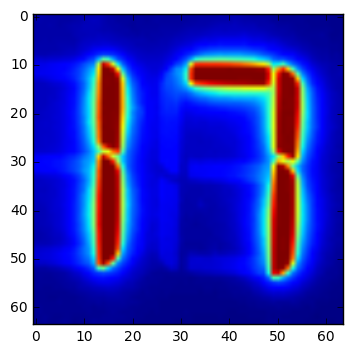

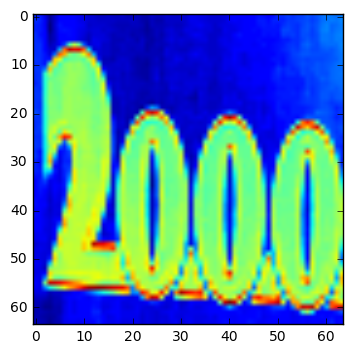

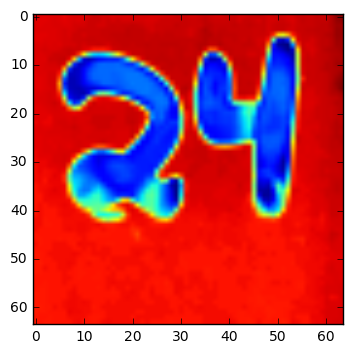

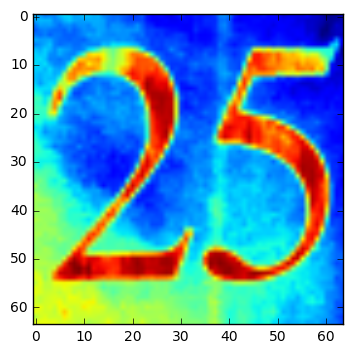

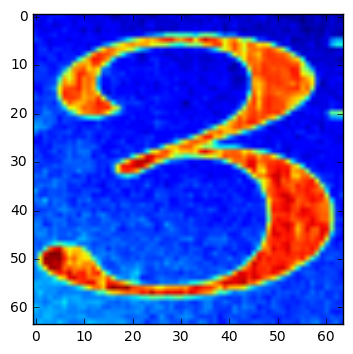

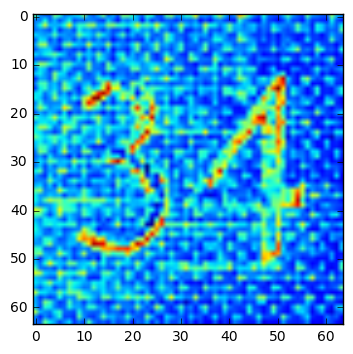

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mycode import genPhotos

%matplotlib inline

photos_dataset, photos_labels, photos_sequences = genPhotos.generateData('mycode/photos')

for sample in range(8):
    image = np.array(photos_dataset[sample, 0, :, :])
    plt.figure()
    plt.imshow(image)

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:** My model was not able to identify the sequences of numbers in these photos as well as the test set data. The model was able to identify the length and digits with about 2/3 the accuracy of the model on the test data:

50% accuracy on photo sequences.
Categorical Accuracy: Length: [0.875], Digits: [0.625, 0.5, 1.0, 0.875, 1.0]

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
## Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
# This cell is for illustration purposes.
# The actual training was performed on a GPU-enabled server and used nb_epoch=1000.

from mycode import SVHNconvnet

SVHNconvnet.trainConvnet(nb_epoch=1, bboxes=True)

Training set (33372, 1, 64, 64) (33372, 11, 5) (33372, 5) (33372, 25)
Test set (13060, 1, 64, 64) (13060, 11, 5) (13060, 5) (13060, 25)
Training sequence distribution: [ 5133 18111  8685  1434     9]
Testing sequence distribution: [2482 8350 2080  146    2]


[[    0  5133 23244 31929 33363]
 [ 9233  3327  1128   156     2]
 [ 6316  3128   983   150     0]
 [ 4342  2966  1057   120     2]
 [ 3509  2807   979   160     0]
 [ 2828  2867  1045   134     1]
 [ 2152  2489   953   130     0]
 [ 1877  2633   960   115     2]
 [ 1582  2378   939   140     0]
 [ 1449  2281   805   121     1]
 [   84  3363  1279   217     1]]


[[    0  2482 10832 12912 13058]
 [ 3693  1144   244    17     0]
 [ 2655  1232   243    16     0]
 [ 1625  1026   217    13     0]
 [ 1235  1080   198     9     0]
 [ 1051  1078   242    12     0]
 [  856   918   182    17     0]
 [  747  1018   239    12     1]
 [  623   835   192     8     0]
 [  556   848   176    15     0]
 [   19  1399   295    29     1]]


Train bo

In [10]:
from mycode import SVHNeval

SVHNeval.evaluate(bboxes=True, notebook=True)

13060/13060 [==============================] - 31s    

[1.6297808968974064, 0.18609340862887097, 0.48756073518651916, 0.60137912946115679, 0.30461194395470464, 0.04375751545785965, 0.002031453472324936, 0.0043467086803839813, 0.96064318529862169, 0.88101071975497702, 0.85758039816232767, 0.93093415007656966, 0.99042879019908114, 0.99984686064318529, 0.50199081163859116]

Accuracy on test set: 0.747626339969
Images loaded: 8

Accuracy on photos: 0.5


Images loaded: 8


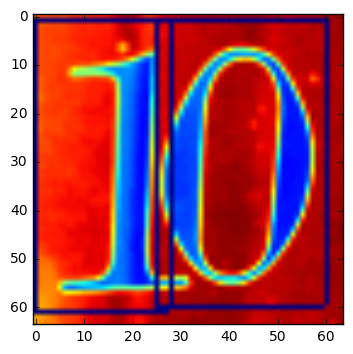

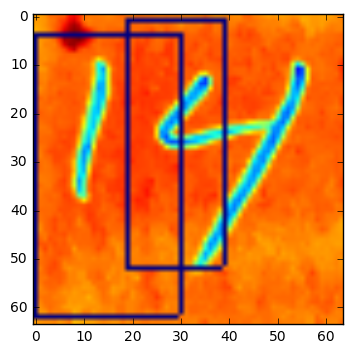

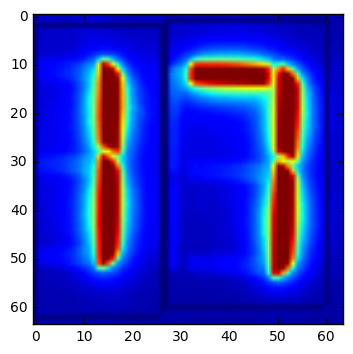

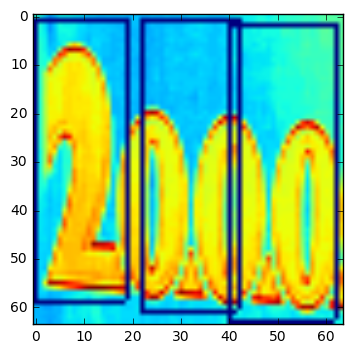

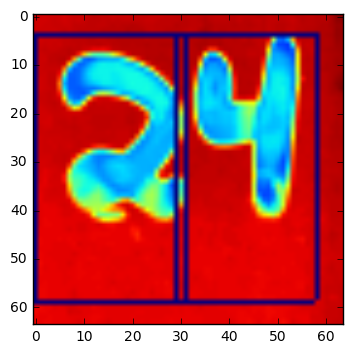

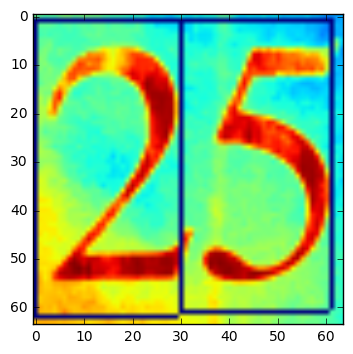

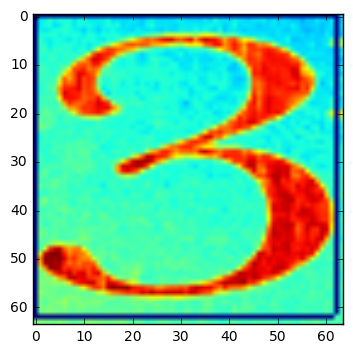

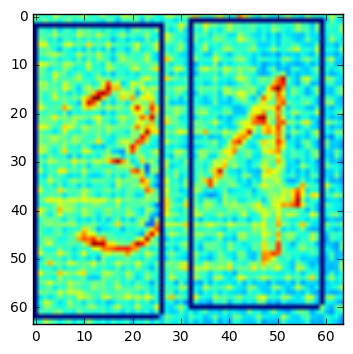

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mycode import genPhotos
from keras.models import Model, load_model

%matplotlib inline

image_size = 64

photos_dataset, photos_labels, photos_sequences = genPhotos.generateData('mycode/photos')
clf = load_model('SVHN-BB-1.h5')
preds = clf.predict(photos_dataset)

for sample in range(8):
    image = np.array(photos_dataset[sample, 0, :, :])
    for index in range(5):
        if preds[6][sample][5 * index + 0] > 0.5:
            top = int((image_size - 1) * preds[6][sample][5 * index + 1])
            left = int((image_size - 1) * preds[6][sample][5 * index + 2])
            bottom = int((image_size - 1) * (preds[6][sample][5 * index + 3] + preds[6][sample][5 * index + 1]))
            right = int((image_size - 1) * (preds[6][sample][5 * index + 4] + preds[6][sample][5 * index + 2]))
            
            if top < 0:
                top = 0
            if bottom > image_size - 1:
                bottom = image_size - 1
            if left < 0:
                left = 0
            if right > image_size - 1:
                right = image_size - 1
            
            image[top:bottom, left] = 0
            image[top:bottom, right] = 0
            image[top, left:right] = 0
            image[bottom, left:right] = 0
    plt.figure()
    plt.imshow(image)

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:** I added an additional 25-node output (5 channels x 5 parameters per box) and after 1000 epochs the network reached the same ~75% accuracy that the model reached without the bounding box information.

The classification results do not change significantly with localization included.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:** The network trained including the bounding box information has the exact same accuracy on my own photos.

The bounding box information isn't perfect, but reasonably identifies the presence and location of the digits in all but two of the photos above.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.